In [2]:
%cd ..

E:\システムトレード入門\trade_system_git_workspace


In [18]:
from pathlib import Pathb
import pandas as pd
import numpy as np
from scipy.special import softmax
import datetime
from pytz import timezone

In [20]:
import bokeh.plotting
from bokeh.models import Range1d, LinearAxis, Div, HoverTool
from bokeh.io import show
from bokeh.io import output_notebook, reset_output, output_file
from bokeh.palettes import d3
output_notebook()

Loading BokehJS ...

In [31]:
import matplotlib.pyplot as plt

In [33]:
from get_stock_price import StockDatabase
from portfolio.trade_transformer import PortfolioTransformer, PortfolioRestrictorIdentity, FeeCalculatorFree
from portfolio.price_supply import StockDBPriceSupplier
from portfolio.rl_base.envs import TradeEnv, TickerSampler, DatetimeSampler, SamplerManager, PortfolioVectorSampler
from portfolio.rl_base.basis_func import ComposeFunction, PriceNormalizeConst, MeanCostPriceNormalizeConst, State2Feature
from visualization import visualize_portfolio_transform_bokeh, make_y_limit_multi, make_y_limit

In [23]:
from utils import get_naive_datetime_from_datetime

In [13]:
jst = timezone("Asia/Tokyo")
start_datetime = jst.localize(datetime.datetime(2020,11,10,0,0,0))
end_datetime = jst.localize(datetime.datetime(2020,11,20,0,0,0))
ticker_number = 9
window = np.arange(0,20)
episode_length = 300
freq_str = "5T"

In [14]:
db_path = Path("db/sub_stock_db/nikkei_255_stock.db")

ticker_codes_df = pd.read_csv(Path("portfolio/rl_base/nikkei225_modified.csv"), header=0)  # 自分で作成
ticker_codes = ticker_codes_df["code"].values.astype(str).tolist()

In [16]:
# stock_db
stock_db = StockDatabase(db_path)

# samplerの設定
ticker_names_sampler = TickerSampler(all_ticker_names=ticker_codes,
                                     sampling_ticker_number=ticker_number)



start_datetime_sampler = DatetimeSampler(start_datetime=start_datetime,
                                         end_datetime=end_datetime,
                                         episode_length=episode_length,
                                         freq_str=freq_str
                                        )

sampler_manager = SamplerManager(ticker_names_sampler=ticker_names_sampler,
                                 datetime_sampler=start_datetime_sampler
                                )


# PriceSupplierの設定
price_supplier = StockDBPriceSupplier(stock_db,
                                      [],  # 最初は何の銘柄コードも指定しない
                                      episode_length,
                                      freq_str,
                                      interpolate=True
                                     )

# PortfolioTransformerの設定
portfolio_transformer = PortfolioTransformer(price_supplier,
                                             portfolio_restrictor=PortfolioRestrictorIdentity(),
                                             use_ohlc="Close",
                                             initial_all_assets=1e6,  # 学習には関係ない
                                             fee_calculator=FeeCalculatorFree()
                                            )

# TradeEnvの設定
trade_env = TradeEnv(portfolio_transformer,
                     sampler_manager,
                     window=np.arange(0,20),
                     fee_const=0.0025
                    )

In [19]:
portfolio_state_list = []
reward_list = []
portfolio_state, reward, done, info = trade_env.reset()
portfolio_state_list.append(portfolio_state.partial("names", "now_price_array", "mean_cost_price_array", "portfolio_vector", "all_assets", "datetime"))
reward_list.append(reward)

while True:
    action = softmax(np.abs(np.random.randn(1+ticker_number)))
    portfolio_state, reward, done, info = trade_env.step(action)
    portfolio_state_list.append(portfolio_state.partial("names", "now_price_array", "mean_cost_price_array", "portfolio_vector", "all_assets", "datetime"))
    reward_list.append(reward)
    if done:
        break

###  bokehによる実装

In [27]:
def visualize_portfolio_rl_bokeh(portfolio_state_list, reward_list, save_path=None, is_save=False, is_show=True, is_jupyter=True):
    all_datetime_array = np.array([get_naive_datetime_from_datetime(one_state.datetime) for one_state in portfolio_state_list])
    reward_array = np.array(reward_list)
    x = np.arange(0, len(portfolio_state_list))

    layout_list = visualize_portfolio_transform_bokeh(portfolio_state_list, is_save=False, is_show=False)

    add_p1 = bokeh.plotting.figure(plot_width=1200,plot_height=300,title="報酬")
    add_p1.line(x, reward_array, legend_label="reward", line_width=2, color="green")
    add_p1.xaxis.major_label_overrides = {str(one_x) : str(all_datetime_array[i]) for i, one_x in enumerate(x)}

    add_p1.yaxis[0].axis_label = "報酬"

    layout_list.extend([add_p1])
    created_figure = bokeh.layouts.column(*layout_list)

    if is_save:
            if save_path.suffix == ".png":
                bokeh.io.export_png(created_figure, filename=save_path)
            elif save_path.suffix == ".html":
                output_file(save_path)
                bokeh.io.save(created_figure, filename=save_path, title="trading process")    
            else:
                raise Exception("The suffix of save_path is must be '.png' or '.html'.")
            
            return None
    if is_show:
        try:
            reset_output()
            if is_jupyter:
                output_notebook()
            show(created_figure)
        except:
            if is_jupyter:
                output_notebook()
            show(created_figure)
            
        return None
        
    if not is_save and not is_show:
        return layout_list

In [28]:
visualize_portfolio_rl_bokeh(portfolio_state_list, reward_list, is_show=True)

Loading BokehJS ...

In [29]:
def visualize_portfolio_rl_matplotlib(portfolio_state_list, reward_list, save_path=None, is_save=False, is_show=True, is_jupyter=True):
    # テータの取り出し
    ticker_names = portfolio_state_list[0].names
    colors = d3["Category20"][len(ticker_names)]

    all_price_array = np.stack([one_state.now_price_array for one_state in portfolio_state_list], axis=1)
    all_portfolio_vector = np.stack([one_state.portfolio_vector for one_state in portfolio_state_list], axis=1)
    all_mean_cost_price_array = np.stack([one_state.mean_cost_price_array for one_state in portfolio_state_list], axis=1)
    all_assets_array = np.array([one_state.all_assets for one_state in portfolio_state_list])
    all_datetime_array = np.array([get_naive_datetime_from_datetime(one_state.datetime) for one_state in portfolio_state_list])
    reward_array = np.array(reward_list)
    x = np.arange(0, len(portfolio_state_list))

    # sorceの作成
    portfolio_vector_source = {"x":x, "datetime":all_datetime_array}
    price_source_x = []
    price_source_y = []

    mean_cost_price_source_x = []
    mean_cost_price_source_y = []

    for i, ticker_name in enumerate(ticker_names):
        portfolio_vector_source[ticker_name] = all_portfolio_vector[i,:]

        price_source_x.append(x)
        price_source_y.append(all_price_array[i,:]/all_price_array[i,0])

        mean_cost_price_source_x.append(x)
        mean_cost_price_source_y.append(all_mean_cost_price_array[i,:]/all_mean_cost_price_array[i,0])

    fig = plt.figure(figsize=(20,15))
    ax1 = fig.add_subplot(411)

    for one_price_x, one_price_y, ticker_name in zip(price_source_x, price_source_y, ticker_names):
        ax1.plot(one_price_x, one_price_y, label=ticker_name)

    ax1.legend(loc="upper right")
    ax1.set_title("normalized price")

    ax2 = fig.add_subplot(412)

    for i, ticker_name in enumerate(ticker_names):
        if i==0:
            ax2.bar(x, portfolio_vector_source[ticker_name], width=1, label=ticker_name)
            offset = portfolio_vector_source[ticker_name].copy()
        else:
            ax2.bar(x, portfolio_vector_source[ticker_name], width=1, label=ticker_name, bottom=offset)
            offset += portfolio_vector_source[ticker_name]

    ax2.legend(loc="upper right")
    ax2.set_title("portfolio vector")

    ax3 = fig.add_subplot(413)

    for one_mean_cost_price_x, one_mean_cost_price_y, ticker_name in zip(mean_cost_price_source_x, mean_cost_price_source_y, ticker_names):
        ax3.plot(one_mean_cost_price_x, one_mean_cost_price_y, label=ticker_name)

    ax3.legend(loc="upper right")
    ax3.set_title("mean_cost_price and all assets")
    y_min, y_max = make_y_limit_multi(mean_cost_price_source_y, lowwer_ratio=0.1, upper_ratio=0.1)
    ax3.set_ylim(y_min, y_max)

    ax4 = ax3.twinx()
    ax4.plot(x, all_assets_array, color="red", linewidth=3, label="all assets")

    ax4.legend(loc="upper left")
    y_min, y_max = make_y_limit(all_assets_array, upper_ratio=0.1, lowwer_ratio=0.1)
    ax4.set_ylim(y_min, y_max)
    
    ax5 = fig.add_subplot(414)
    ax5.plot(x, reward_array, color="green")
    ax5.set_title("reward")
    
    if is_save:
            if save_path.suffix == ".png":
                  fig.savefig(save_path)
            else:
                raise Exception("The suffix of save_path is must be '.png' or '.html'.")
            
    if is_show:
        plt.show()
    else:
        plt.close(fig)

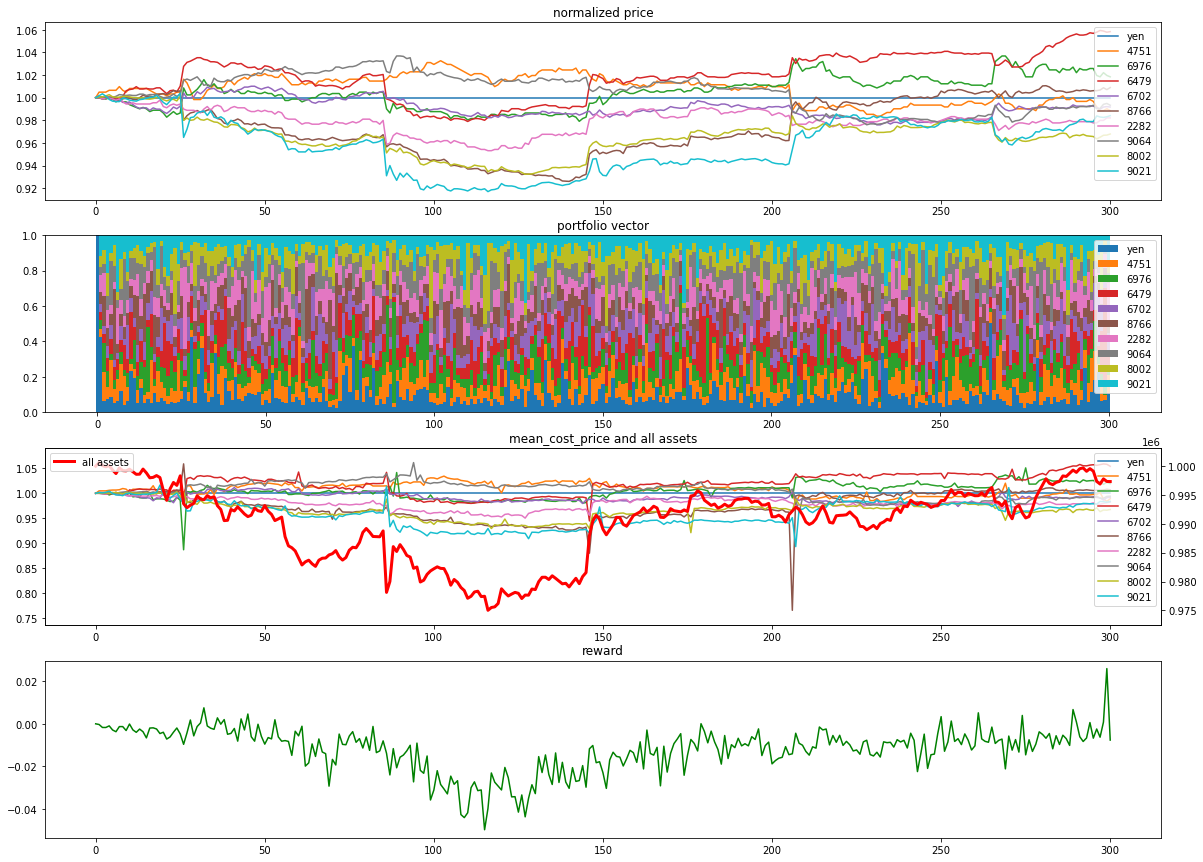

In [34]:
visualize_portfolio_rl_matplotlib(portfolio_state_list, reward_list, is_show=True)